In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
  
from sklearn import model_selection, preprocessing, metrics
from sklearn.metrics import mean_squared_error, roc_auc_score, log_loss
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold
from sklearn.preprocessing import Imputer 

import lightgbm as lgb

#import lightgbm as lgb
#import xgboost as xgb

from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from fastai.structured import *
from fastai.column_data import *
PATH = 'data/'

import pytz # $ pip install pytz
from pytz import country_timezones
import pycountry

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning:

numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.



# Functions (Feature engineering)

In [2]:
PATH = 'data/'

#the columns that will be parsed to extract the fields from the jsons
cols_to_parse = ['device', 'geoNetwork', 'totals', 'trafficSource']
def read_parse_dataframe(file_name):
    #full path for the data file
    path = PATH + file_name
    #read the data file, convert the columns in the list of columns to parse using json loader,
    #convert the `fullVisitorId` field as a string
    data_df = pd.read_csv(path, 
        converters={column: json.loads for column in cols_to_parse}, 
        dtype={'fullVisitorId': 'str'})
    #parse the json-type columns
    for col in cols_to_parse:
        #each column became a dataset, with the columns the fields of the Json type object
        json_col_df = json_normalize(data_df[col])
        json_col_df.columns = [f"{col}_{sub_col}" for sub_col in json_col_df.columns]
        #we drop the object column processed and we add the columns created from the json fields
        data_df = data_df.drop(col, axis=1).merge(json_col_df, right_index=True, left_index=True)
    return data_df

#def process_date_time(data_df):
#    print("process date time ...")
#    
#    data_df['date'] = data_df['date'].astype(str)
#    data_df["date"] = data_df["date"].apply(lambda x : x[:4] + "-" + x[4:6] + "-" + x[6:])
#    data_df["date"] = pd.to_datetime(data_df["date"])   
#    data_df["year"] = data_df['date'].dt.year
#    data_df["month"] = data_df['date'].dt.month
#    data_df["day"] = data_df['date'].dt.day
#    data_df["weekday"] = data_df['date'].dt.weekday
#    data_df['weekofyear'] = data_df['date'].dt.weekofyear
#    data_df['month_unique_user_count'] = data_df.groupby('month')['fullVisitorId'].transform('nunique')
#    data_df['day_unique_user_count'] = data_df.groupby('day')['fullVisitorId'].transform('nunique')
#    data_df['weekday_unique_user_count'] = data_df.groupby('weekday')['fullVisitorId'].transform('nunique')
#    data_df['month_unique_s_count'] = data_df.groupby('month')['sessionId'].transform('nunique')
#    data_df['day_unique_s_count'] = data_df.groupby('day')['sessionId'].transform('nunique')
#    data_df['weekday_unique_s_count'] = data_df.groupby('weekday')['sessionId'].transform('nunique')
#    return data_df

def process_format(data_df):
    print("process format ...")
    
    for col in ['visitNumber', 'totals_hits', 'totals_pageviews']:
        data_df[col] = data_df[col].astype(float)
    data_df['trafficSource_adwordsClickInfo.isVideoAd'].fillna(True, inplace=True)
    data_df['trafficSource_isTrueDirect'].fillna(False, inplace=True)
    return data_df
    
def process_device(data_df):
    print("process device ...")
    
    data_df['browser_category'] = data_df['device_browser'] + '_' + data_df['device_deviceCategory']
    data_df['browser_operatingSystem'] = data_df['device_browser'] + '_' + data_df['device_operatingSystem']
    data_df['source_country'] = data_df['trafficSource_source'] + '_' + data_df['geoNetwork_country']
    return data_df

def process_geo_network(data_df):
    print("process geo network ...")
    
    data_df['sum_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('sum')
    data_df['count_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('count')
    data_df['mean_pageviews_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_pageviews'].transform('mean')
    data_df['sum_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('sum')
    data_df['count_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('count')
    data_df['mean_hits_per_network_domain'] = data_df.groupby('geoNetwork_networkDomain')['totals_hits'].transform('mean')
    return data_df

def process_geo_network_names(data_df):
    print("process geo network names ...")
    
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == '(not set)'] = float('NaN')
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Russia'] = 'Russian Federation'
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'South Korea'] = 'Korea, Republic of'
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Côte d’Ivoire'] = "Côte d'Ivoire"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Cape Verde'] = "Cabo Verde"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Macedonia (FYROM)'] = "Macedonia, Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Myanmar (Burma)'] = "Myanmar"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Kosovo'] = "Serbia"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Laos'] = "Thailand"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Turks & Caicos Islands'] = "Turks and Caicos Islands"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Palestine'] = "Palestine, State of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Congo - Kinshasa'] = "Congo, The Democratic Republic of the"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Macau'] = "Hong Kong"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Brunei'] = "Brunei Darussalam"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Sint Maarten'] = "Sint Maarten (Dutch part)"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Iran'] = "Iran, Islamic Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Vincent and Grenadines'] = \
                                                                   "Saint Vincent and the Grenadines"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'U.S. Virgin Islands'] = "Virgin Islands, U.S."
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Syria'] = "Syrian Arab Republic"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Caribbean Netherlands'] = "Venezuela, Bolivarian Republic of"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Congo - Brazzaville'] = \
                                                                   "Congo, The Democratic Republic of the"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Martin'] = "Saint Martin (French part)"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'São Tomé and Príncipe'] = "Sao Tome and Principe"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Saint Helena'] =  \
                                                                   "Saint Helena, Ascension and Tristan da Cunha"
    data_df['geoNetwork_country'][data_df['geoNetwork_country'] == 'Micronesia'] = "Micronesia, Federated States of"
    
    return data_df

def process_geo_network_names_with_mask(data_df, mask):
    print("process geo network names with mask ...")
    
    data_df['geoNetwork_country'] = data_df['geoNetwork_country'][mask].apply(lambda x: x.replace('&','and'))
    data_df['geoNetwork_country'] = data_df['geoNetwork_country'][mask].apply(lambda x: x.replace('St.','Saint'))
    return data_df
    
def process_geo_timezone(data_df, mask):
    print("process geo timezone ...")
    
    data_df['geoNetwork_country'] = data_df[mask]['geoNetwork_country'].apply(lambda x: pycountry.countries.lookup(x).alpha_2)
    data_df['time'] = pd.to_datetime(data_df['visitStartTime'], unit='s')
    data_df['time'] = data_df[mask].apply(lambda x: x['time'].tz_localize( \
                     country_timezones(x['geoNetwork_country'])[0], errors='coerce', ambiguous='NaT'), axis=1)
    data_df['time'] = data_df['time'].astype(str).str[:-6]
    data_df['time'] = pd.to_datetime(data_df['time'])
    return data_df

def process_unique_user_per_span(data_df):
    data_df['month_unique_user_count'] = data_df.groupby('timeMonth')['fullVisitorId'].transform('nunique')
    data_df['day_unique_user_count'] = data_df.groupby('timeDay')['fullVisitorId'].transform('nunique')
    data_df['weekday_unique_user_count'] = data_df.groupby('timeDayofweek')['fullVisitorId'].transform('nunique')
    data_df['weekofyear_unique_user_count'] = data_df.groupby('timeWeekofyear')['fullVisitorId'].transform('nunique')
    
    data_df['month_unique_s_count'] = data_df.groupby('timeMonth')['sessionId'].transform('nunique')
    data_df['day_unique_s_count'] = data_df.groupby('timeDay')['sessionId'].transform('nunique')
    data_df['weekday_unique_s_count'] = data_df.groupby('timeDayofweek')['sessionId'].transform('nunique')
    data_df['weekofyear_unique_s_count'] = data_df.groupby('timeWeekofyear')['sessionId'].transform('nunique')
    return data_df

def process_totals(data_df):
    print("process totals ...")
    
    data_df['totals_hits'] = np.log1p(data_df['totals_hits']) #this was ln()
    data_df['totals_pageviews'] = np.log1p(data_df['totals_pageviews'].fillna(0)) #this was ln()
    
    data_df['hits_per_pageViews'] = data_df['totals_hits'] / (data_df['totals_pageviews'] + 1)
    data_df['mean_hits_per_pageViews'] = data_df['totals_hits'] / (data_df['totals_pageviews'] + 1)
    data_df['sum_hits_per_pageViews'] = data_df['totals_hits'] / (data_df['totals_pageviews'] + 1)
    data_df['max_hits_per_pageViews'] = data_df['totals_hits'] / (data_df['totals_pageviews'] + 1)
    data_df['min_hits_per_pageViews'] = data_df['totals_hits'] / (data_df['totals_pageviews'] + 1)
    
    data_df['mean_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('sum')
    data_df['max_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('max')
    data_df['min_hits_per_day'] = data_df.groupby(['timeDay'])['totals_hits'].transform('min')
    
    data_df['mean_hits_per_week']   = data_df.groupby(['timeWeek'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_week'] = data_df.groupby(['timeWeek'])['totals_hits'].transform('sum')
    data_df['max_hits_per_week'] = data_df.groupby(['timeWeek'])['totals_hits'].transform('max')
    data_df['min_hits_per_week'] = data_df.groupby(['timeWeek'])['totals_hits'].transform('min')
    
    data_df['mean_hits_per_month']   = data_df.groupby(['timeMonth'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_month'] = data_df.groupby(['timeMonth'])['totals_hits'].transform('sum')
    data_df['max_hits_per_month'] = data_df.groupby(['timeMonth'])['totals_hits'].transform('max')
    data_df['min_hits_per_month'] = data_df.groupby(['timeMonth'])['totals_hits'].transform('min')
    
    data_df['mean_hits_per_year']   = data_df.groupby(['timeYear'])['totals_hits'].transform('mean')
    data_df['sum_hits_per_year'] = data_df.groupby(['timeYear'])['totals_hits'].transform('sum')
    data_df['max_hits_per_year'] = data_df.groupby(['timeYear'])['totals_hits'].transform('max')
    data_df['min_hits_per_year'] = data_df.groupby(['timeYear'])['totals_hits'].transform('min')
    return data_df

## Load data

In [3]:
train_df = read_parse_dataframe('train.csv')
#train_df = process_date_time(train_df)
test_df = read_parse_dataframe('test.csv')
#test_df = process_date_time(test_df)

## Drop columns columns with single unique

In [4]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

## Drop only one not null unique value

In [5]:
train_df.drop(['trafficSource_campaignCode'], axis=1, inplace=True)

## Convert transactionRevenue

In [6]:
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].astype(float)
train_df['totals_transactionRevenue'] = train_df['totals_transactionRevenue'].fillna(0)

#train_df['totals_transactionRevenue'] = np.log1p(train_df['totals_transactionRevenue'])

In [ ]:
#train_df.to_feather("train_df_withoutFeatures")
#test_df.to_feather("test_df_withoutFeatures")

In [ ]:
#train_df = pd.read_feather("train_df_withoutFeatures")
#test_df = pd.read_feather("test_df_withoutFeatures")

# Features

In [7]:
train_df = process_format(train_df)
train_df = process_device(train_df)
train_df = process_geo_network(train_df)

mask = train_df['geoNetwork_country'].notnull()
train_df = process_geo_network_names_with_mask(train_df, mask) 
train_df = process_geo_network_names(train_df)
mask = train_df['geoNetwork_country'].notnull() #some values are set to NaN after process geo names TODO: find out why
train_df = process_geo_network_names_with_mask(train_df, mask)
train_df = process_geo_timezone(train_df, mask)

train_df['time'][train_df['time'].isna()] = pd.to_datetime(train_df['visitStartTime'], unit='s')

process format ...
process device ...
process geo network ...
process geo network names with mask ...
process geo network names ...
process geo network names with mask ...
process geo timezone ...


In [8]:
train_df['time'] = train_df['time'].fillna(pd.to_datetime(train_df['visitStartTime'], unit='s'))
train_df['time'].isna().sum()

0

In [9]:
test_df = process_format(test_df)
test_df = process_device(test_df)
#test_df = process_totals(test_df)
test_df = process_geo_network(test_df)

mask = test_df['geoNetwork_country'].notnull()
test_df = process_geo_network_names_with_mask(test_df, mask)
test_df = process_geo_network_names(test_df)
mask = test_df['geoNetwork_country'].notnull()  #some values are set to NaN after process geo names TODO: find out why
test_df = process_geo_network_names_with_mask(test_df, mask)
test_df = process_geo_timezone(test_df, mask)

test_df['time'][test_df['time'].isna()] = pd.to_datetime(test_df['visitStartTime'], unit='s')

process format ...
process device ...
process geo network ...
process geo network names with mask ...
process geo network names ...
process geo network names with mask ...
process geo timezone ...


In [10]:
test_df['time'] = test_df['time'].fillna(pd.to_datetime(train_df['visitStartTime'], unit='s'))
test_df['time'].isna().sum()

0

In [11]:
#train_df['timezone_date'] = train_df['time'].dt.normalize()
#test_df['timezone_date'] = test_df['time'].dt.normalize()

In [12]:
add_datepart(train_df, "time", time=True, drop=False)
add_datepart(test_df, "time", time=True, drop=False)

In [13]:
train_df['timeWeekofyear'] = train_df['time'].dt.weekofyear
test_df['timeWeekofyear'] = test_df['time'].dt.weekofyear

In [14]:
train_df = process_unique_user_per_span(train_df)
test_df = process_unique_user_per_span(test_df)
train_df = process_totals(train_df)
test_df = process_totals(test_df)

process totals ...
process totals ...


In [15]:
#col_x = ['sum_pageviews_per_network_domain', 'sum_hits_per_network_domain',
#       'mean_hits_per_network_domain',
#       'mean_pageviews_per_network_domain', 'totals_hits',
#       'totals_pageviews', 'count_hits_per_network_domain', 'count_pageviews_per_network_domain']

#for i in col_x:
#    train_df[i+'_square'] =  train_df[i] ** 2
#    test_df[i+'_square']  = test_df[i] ** 2

In [16]:
cols_to_drop = [col for col in train_df.columns if train_df[col].nunique(dropna=False) == 1]
train_df.drop(cols_to_drop, axis=1, inplace=True)
test_df.drop([col for col in cols_to_drop if col in test_df.columns], axis=1, inplace=True)

In [17]:
pd.set_option('display.max_rows', 1000) 
train_df.isna().sum()

channelGrouping                                      0
date                                                 0
fullVisitorId                                        0
sessionId                                            0
visitId                                              0
visitNumber                                          0
visitStartTime                                       0
device_browser                                       0
device_deviceCategory                                0
device_isMobile                                      0
device_operatingSystem                               0
geoNetwork_city                                      0
geoNetwork_continent                                 0
geoNetwork_country                                1468
geoNetwork_metro                                     0
geoNetwork_networkDomain                             0
geoNetwork_region                                    0
geoNetwork_subContinent                              0
totals_bou

In [18]:
train_df.nunique(dropna=False)

channelGrouping                                      8
date                                               366
fullVisitorId                                   714167
sessionId                                       902755
visitId                                         886303
visitNumber                                        384
visitStartTime                                  887159
device_browser                                      54
device_deviceCategory                                3
device_isMobile                                      2
device_operatingSystem                              20
geoNetwork_city                                    649
geoNetwork_continent                                 6
geoNetwork_country                                 217
geoNetwork_metro                                    94
geoNetwork_networkDomain                         28064
geoNetwork_region                                  376
geoNetwork_subContinent                             23
totals_bou

# Splitting Data into Categorical/Numerical

In [19]:
num_cols = ['month_unique_user_count', 'day_unique_user_count', 'weekday_unique_user_count', 'weekofyear_unique_user_count',
            'month_unique_s_count','day_unique_s_count', 'weekday_unique_s_count', 'weekofyear_unique_s_count',
            'totals_hits', 'totals_pageviews', 'hits_per_pageViews', 'mean_hits_per_pageViews', 'sum_hits_per_pageViews',
            'max_hits_per_pageViews', 'min_hits_per_pageViews', 'mean_hits_per_week', 'sum_hits_per_week', 'max_hits_per_week',
            'mean_hits_per_month', 'sum_hits_per_month', 'max_hits_per_month',
            'mean_hits_per_year', 'sum_hits_per_year', 
            'mean_hits_per_day', 'sum_hits_per_day', 'max_hits_per_day', 
            'sum_pageviews_per_network_domain', 'count_pageviews_per_network_domain', 'mean_pageviews_per_network_domain',
            'sum_hits_per_network_domain', 'count_hits_per_network_domain', 'mean_hits_per_network_domain']

            #'sum_pageviews_per_network_domain_square', 'sum_hits_per_network_domain_square', 
            #'mean_hits_per_network_domain_square', 'mean_pageviews_per_network_domain_square', 'totals_hits_square', 
            #'totals_pageviews_square', 'count_hits_per_network_domain_square', 'count_pageviews_per_network_domain_square'
#single unique columns:
#'max_hits_per_year', 'min_hits_per_year', 'min_hits_per_month', 'min_hits_per_week', 'min_hits_per_day',
#

not_used_cols = ["visitNumber", "fullVisitorId", "sessionId", "visitId", "visitStartTime", 
                 'trafficSource_referralPath', "date", "timezone_date", "time", 'totals_transactionRevenue']
cat_cols = [col for col in train_df.columns if col not in num_cols and col not in not_used_cols]

In [20]:
#imputer = Imputer()
#train_df[num_cols] = imputer.fit_transform(train_df[num_cols])
#test_df[num_cols] = imputer.fit_transform(test_df[num_cols])

In [21]:
train_df.shape, test_df.shape, len(num_cols) + len(cat_cols)

((903653, 86), (804684, 85), 77)

In [22]:
train_df = train_df.sort_values('time')
test_df = test_df.sort_values('time')

In [23]:
#train_df.reset_index().to_feather("train_df_withFeatures")
#test_df.reset_index().to_feather("test_df_withFeatures")

In [24]:
#train_df = pd.read_feather("train_df_withFeatures")
#test_df = pd.read_feather("test_df_withFeatures")

In [25]:
len(train_df['fullVisitorId'].unique())

714167

In [26]:
len(test_df['fullVisitorId'].unique())

617242

# Binary classification for revenue > 0

In [28]:
dep = 'totals_transactionRevenue'
test_df[dep] = 0

In [46]:
lgb_train = train_df.copy()
lgb_test = test_df.copy()

In [48]:
lgb_train[lgb_train.select_dtypes(include=['bool']).columns] = lgb_train.select_dtypes(include=['bool']).astype(int)
lgb_test[lgb_test.select_dtypes(include=['bool']).columns] = lgb_test.select_dtypes(include=['bool']).astype(int)

In [49]:
lgb_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804684 entries, 613297 to 483292
Data columns (total 86 columns):
channelGrouping                                 804684 non-null object
date                                            804684 non-null int64
fullVisitorId                                   804684 non-null object
sessionId                                       804684 non-null object
visitId                                         804684 non-null int64
visitNumber                                     804684 non-null float64
visitStartTime                                  804684 non-null int64
device_browser                                  804684 non-null object
device_deviceCategory                           804684 non-null object
device_isMobile                                 804684 non-null int32
device_operatingSystem                          804684 non-null object
geoNetwork_city                                 804684 non-null object
geoNetwork_continent               

In [68]:
for v in cat_cols:
    lgb_train[v] = lgb_train[v].astype('category').cat.as_ordered()

apply_cats(lgb_test, lgb_train)
   
#for f in cat_cols:
#    print(f)
#    lgb_train[f], indexer = pd.factorize(lgb_train[f])
#    lgb_test[f] = indexer.get_indexer(lgb_test[f])

    
#lgb_train['fullVisitorId'], indexer = pd.factorize(lgb_train['fullVisitorId'])
#lgb_test['fullVisitorId'] = indexer.get_indexer(lgb_test['fullVisitorId'])

#lgb_train['time'], indexer = pd.factorize(lgb_train['time'])
#lgb_test['time'] = indexer.get_indexer(lgb_test['time'])

In [69]:
for v in num_cols:
    lgb_train[v] = lgb_train[v].astype('float32')
    lgb_test[v] = lgb_test[v].astype('float32')

In [71]:
#lgb_train.drop(dep, axis=1, inplace=True)
#lgb_test.drop(dep, axis=1, inplace=True)

In [72]:
#lgb_train.drop('zero_prob', axis=1, inplace=True)
#lgb_train.drop('zero_prob', axis=1, inplace=True)

In [73]:
len(lgb_train.columns),len(lgb_test.columns)

(86, 86)

In [86]:
lgb_train.reset_index().to_feather("lgb_train")
lgb_test.reset_index().to_feather("lgb_test")

In [24]:
#lgb_train = pd.read_feather("lgb_train")
#lgb_test = pd.read_feather("lgb_test")

In [ ]:
#how many iterations:
#100 * colsample_bytree * n_features / depth for lightgbm or xgboost.
#100 * 0.7 * len(train_features) / 8

In [120]:
100 * 0.7 * len(train_features) / 8

673.75

In [121]:
def get_feature_importances(data, shuffle, seed=None):

    train_features = [_f for _f in lgb_train.columns if _f not in not_used_cols]

    y = (data['totals_transactionRevenue'].fillna(0) > 0).astype(np.uint8).copy()
    if shuffle:
        # Here you could as well use a binomial distribution
        y = (data['totals_transactionRevenue'].fillna(0) > 0).astype(np.uint8).copy().sample(frac=1.0)
    
    dtrain = lgb.Dataset(data[train_features], y, silent=True)
    
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'rf',
        'subsample': 0.623,
        'colsample_bytree': 0.7,
        'num_leaves': 127,
        'max_depth': 10,
        'seed': seed,
        'bagging_freq': 1,
        'n_jobs': -1
    }
    
    '''clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.001,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        seed = seed,
        random_state=1,
        n_jobs=-1
    )'''
    
    clf = lgb.train(params=lgb_params, train_set=dtrain, num_boost_round=700)
    
    imp_df = pd.DataFrame()
    imp_df["feature"] = list(train_features)
    imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
    imp_df["importance_split"] = clf.feature_importance(importance_type='split')
    imp_df['trn_score'] = roc_auc_score(y, clf.predict(data[train_features]))
    
    return imp_df

In [123]:
np.random.seed(123)
# Get the actual importance, i.e. without shuffling
actual_imp_df = get_feature_importances(data=lgb_train, shuffle=False)

In [124]:
actual_imp_df.head()

,feature,importance_gain,importance_split,trn_score
0,channelGrouping,3837.229825,258,0.986317
1,device_browser,0.000000,0,0.986317
2,device_deviceCategory,9906.133197,2106,0.986317
3,device_isMobile,6208.603857,1055,0.986317
4,device_operatingSystem,3501.821707,327,0.986317


In [127]:
null_imp_df = pd.DataFrame()
nb_runs = 100
import time
start = time.time()
dsp = ''
for i in range(nb_runs):
    # Get current run importances
    imp_df = get_feature_importances(data=lgb_train, shuffle=True)
    imp_df['run'] = i + 1 
    # Concat the latest importances with the old ones
    null_imp_df = pd.concat([null_imp_df, imp_df], axis=0)
    # Erase previous message
    for l in range(len(dsp)):
        print('\b', end='', flush=True)
    # Display current run and time used
    spent = (time.time() - start) / 60
    dsp = 'Done with %4d of %4d (Spent %5.1f min)' % (i + 1, nb_runs, spent)
    print(dsp, end='', flush=True)

Done with  100 of  100 (Spent 668.9 min)

In [128]:
null_imp_df.head()

,feature,importance_gain,importance_split,trn_score,run
0,channelGrouping,8.532943,23,0.744048,1
1,device_browser,8.209571,18,0.744048,1
2,device_deviceCategory,259.663642,577,0.744048,1
3,device_isMobile,58.067198,141,0.744048,1
4,device_operatingSystem,22.260458,45,0.744048,1


In [129]:
def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

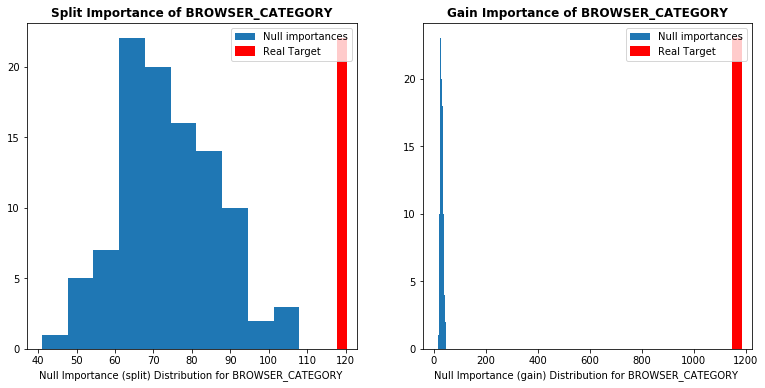

In [130]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='browser_category') #compare

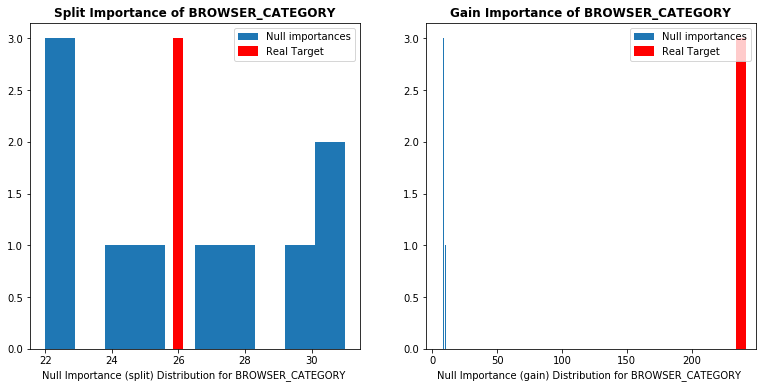

In [94]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='browser_category')

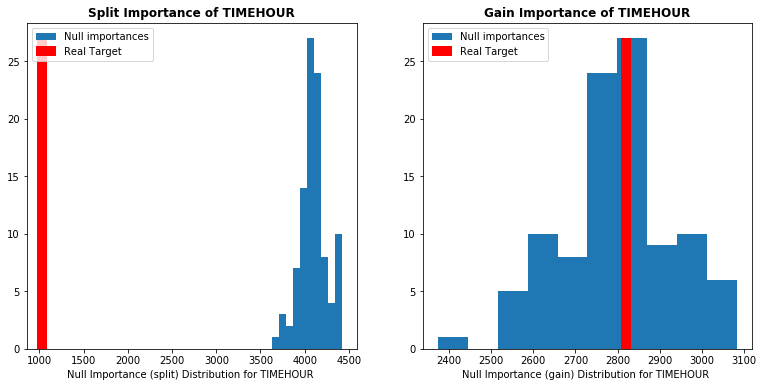

In [131]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='timeHour')

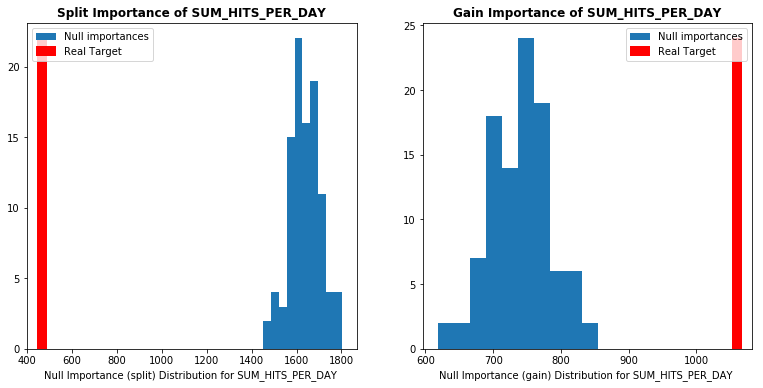

In [132]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='sum_hits_per_day')#compare

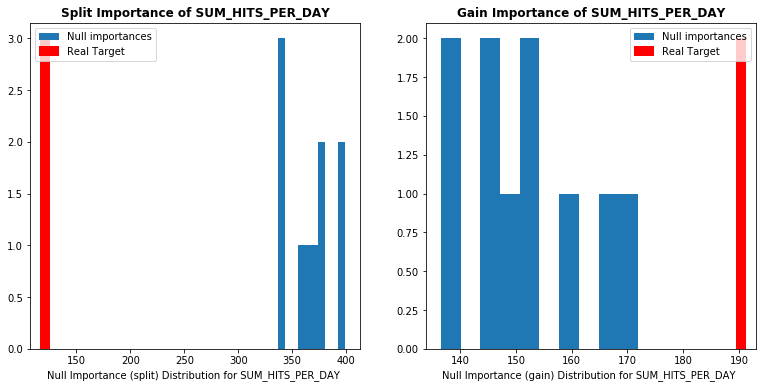

In [96]:
display_distributions(actual_imp_df_=actual_imp_df, null_imp_df_=null_imp_df, feature_='sum_hits_per_day')

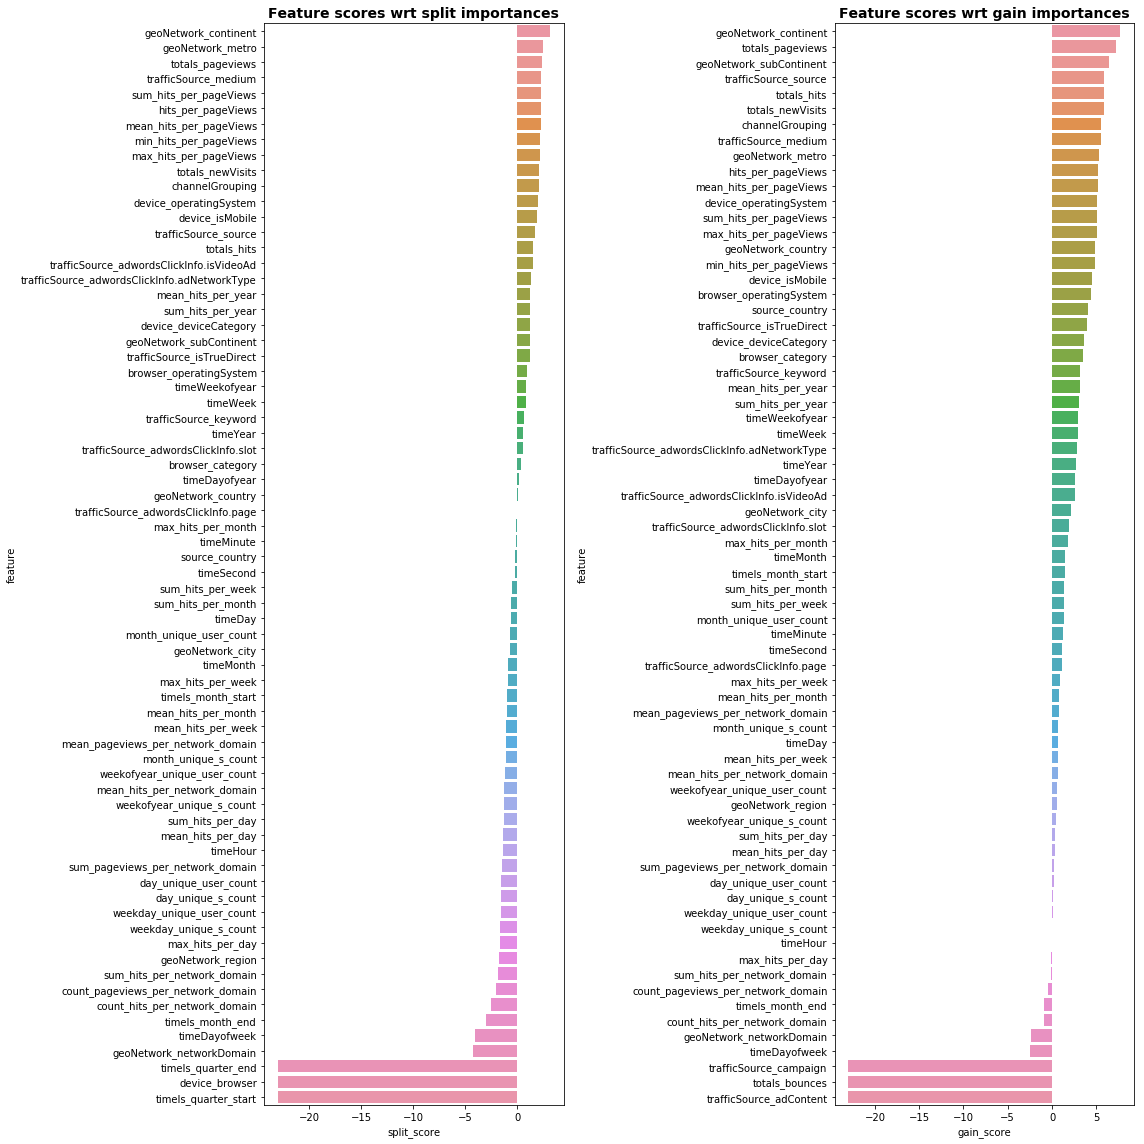

In [133]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout() #compare

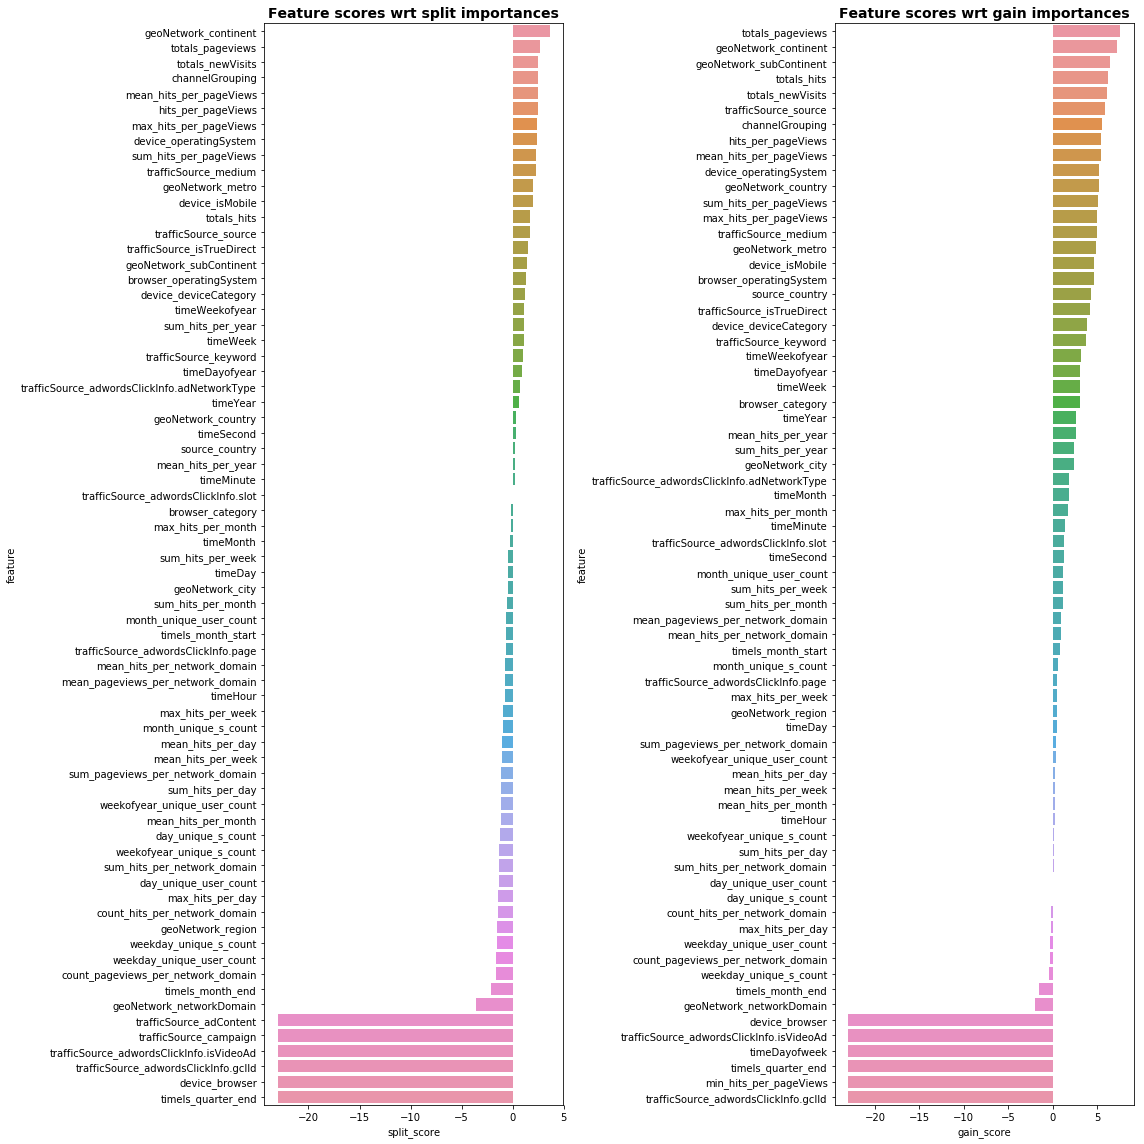

In [97]:
feature_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps_gain = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps_gain = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].mean()
    gain_score = np.log(1e-10 + f_act_imps_gain / (1 + np.percentile(f_null_imps_gain, 75)))  # Avoid didvide by zero
    f_null_imps_split = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps_split = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].mean()
    split_score = np.log(1e-10 + f_act_imps_split / (1 + np.percentile(f_null_imps_split, 75)))  # Avoid didvide by zero
    feature_scores.append((_f, split_score, gain_score))

scores_df = pd.DataFrame(feature_scores, columns=['feature', 'split_score', 'gain_score'])

plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()

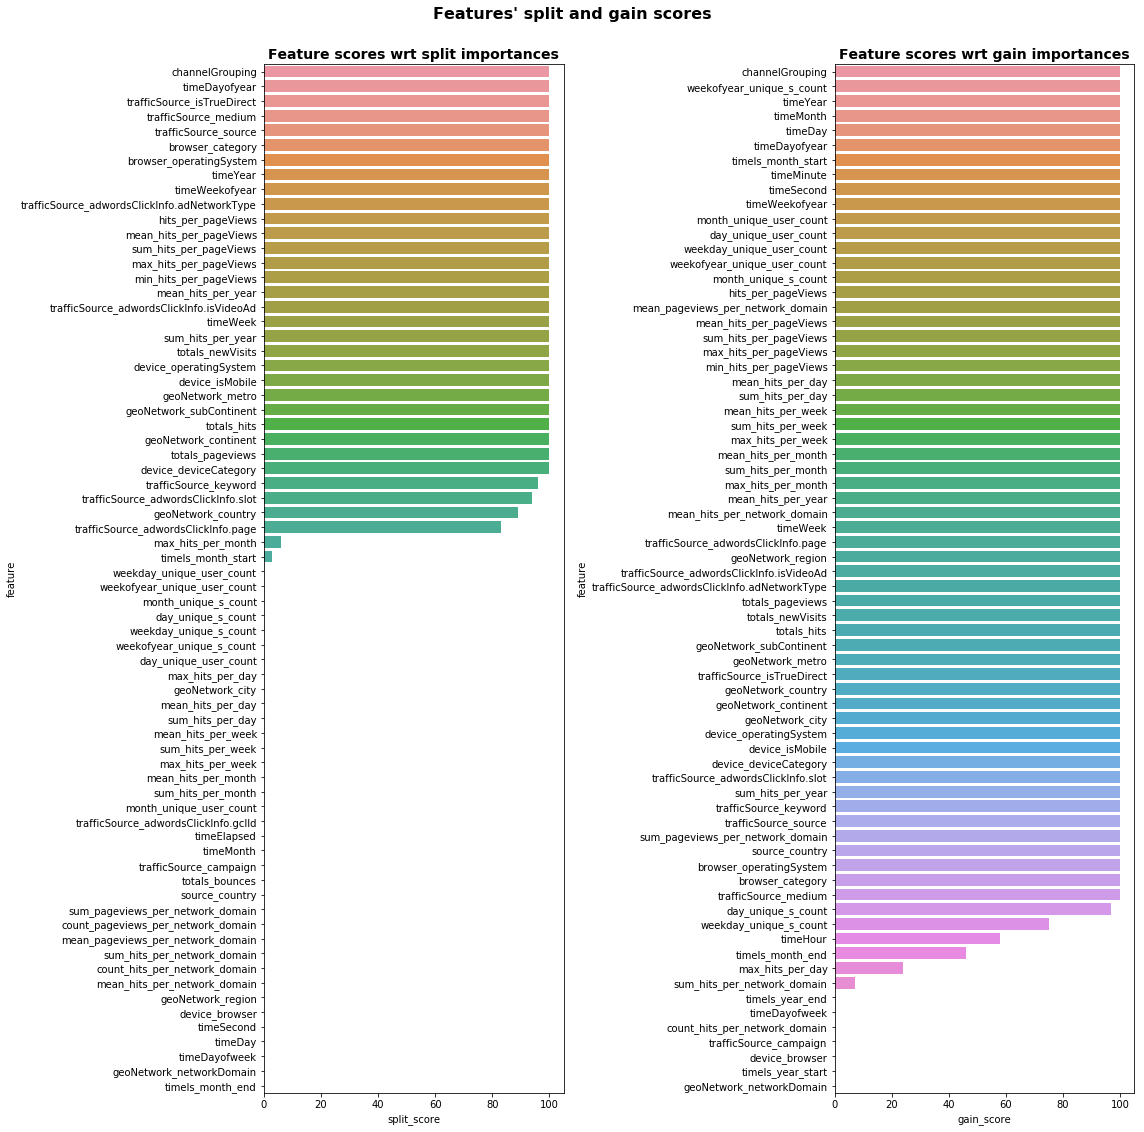

In [136]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

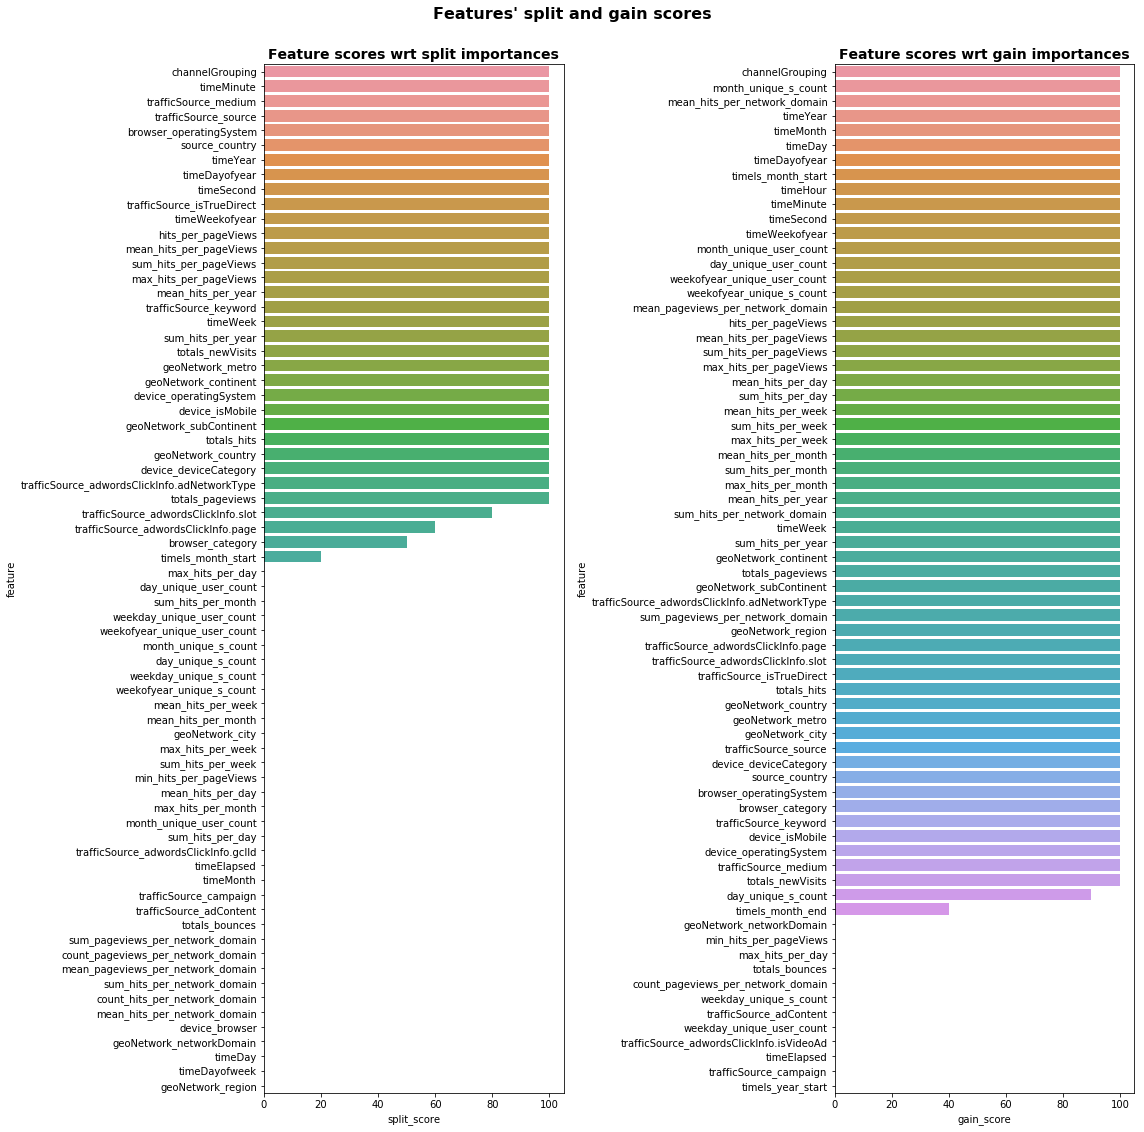

In [98]:
correlation_scores = []
for _f in actual_imp_df['feature'].unique():
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_gain'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_gain'].values
    gain_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    f_null_imps = null_imp_df.loc[null_imp_df['feature'] == _f, 'importance_split'].values
    f_act_imps = actual_imp_df.loc[actual_imp_df['feature'] == _f, 'importance_split'].values
    split_score = 100 * (f_null_imps < np.percentile(f_act_imps, 25)).sum() / f_null_imps.size
    correlation_scores.append((_f, split_score, gain_score))

corr_scores_df = pd.DataFrame(correlation_scores, columns=['feature', 'split_score', 'gain_score'])

fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(1, 2)
# Plot Split importances
ax = plt.subplot(gs[0, 0])
sns.barplot(x='split_score', y='feature', data=corr_scores_df.sort_values('split_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt split importances', fontweight='bold', fontsize=14)
# Plot Gain importances
ax = plt.subplot(gs[0, 1])
sns.barplot(x='gain_score', y='feature', data=corr_scores_df.sort_values('gain_score', ascending=False).iloc[0:70], ax=ax)
ax.set_title('Feature scores wrt gain importances', fontweight='bold', fontsize=14)
plt.tight_layout()
plt.suptitle("Features' split and gain scores", fontweight='bold', fontsize=16)
fig.subplots_adjust(top=0.93)

In [137]:
def score_feature_selection(df=None, train_features=None, cat_feats=None, target=None):
    # Fit LightGBM 
    dtrain = lgb.Dataset(lgb_train[train_features], target, free_raw_data=False, silent=True)
    lgb_params = {
        'objective': 'binary',
        'boosting_type': 'gbdt',
        'learning_rate': .1,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'num_leaves': 31,
        'max_depth': -1,
        'seed': 13,
        'n_jobs': -1,
        'min_split_gain': .00001,
        'reg_alpha': .00001,
        'reg_lambda': .00001,
        'metric': 'auc'
    }
    
    # Fit the model
    hist = lgb.cv(
        params=lgb_params, 
        train_set=dtrain, 
        num_boost_round=2000,
        nfold=5,
        stratified=True,
        shuffle=True,
        early_stopping_rounds=50,
        verbose_eval=0,
        seed=17
    )
    
    # Return the last mean / std values 
    return hist['auc-mean'][-1], hist['auc-stdv'][-1]


In [ ]:
# features = [f for f in data.columns if f not in ['SK_ID_CURR', 'TARGET']]
# score_feature_selection(df=data[features], train_features=features, target=data['TARGET'])

target = (train_df['totals_transactionRevenue'].fillna(0) > 0).astype(np.uint8)

for threshold in [0, 10, 20, 30 , 40, 50 ,60 , 70, 80 , 90, 95, 99]:
    split_feats = [_f for _f, _score, _ in correlation_scores if _score >= threshold]
    split_cat_feats = [_f for _f, _score, _ in correlation_scores if (_score >= threshold) & (_f in cat_cols)]
    gain_feats = [_f for _f, _, _score in correlation_scores if _score >= threshold]
    gain_cat_feats = [_f for _f, _, _score in correlation_scores if (_score >= threshold) & (_f in cat_cols)]
                                                                                             
    print('Results for threshold %3d' % threshold)
    split_results = score_feature_selection(df=lgb_train, train_features=split_feats, cat_feats=split_cat_feats, target=target)
    print('\t SPLIT : %.6f +/- %.6f' % (split_results[0], split_results[1]))
    gain_results = score_feature_selection(df=lgb_train, train_features=gain_feats, cat_feats=gain_cat_feats, target=target)
    print('\t GAIN  : %.6f +/- %.6f' % (gain_results[0], gain_results[1]))

Results for threshold   0
	 SPLIT : 0.985821 +/- 0.000413
	 GAIN  : 0.985821 +/- 0.000413
Results for threshold  10
	 SPLIT : 0.986968 +/- 0.000341
	 GAIN  : 0.985870 +/- 0.000893
Results for threshold  20
	 SPLIT : 0.986968 +/- 0.000341
	 GAIN  : 0.985870 +/- 0.000893
Results for threshold  30
	 SPLIT : 0.986968 +/- 0.000341


In [ ]:
'''folds = StratifiedKFold(n_splits=5) #GroupKFold(n_splits=5)

train_features = [_f for _f in lgb_train.columns if _f not in not_used_cols]

oof_clf_preds = np.zeros(lgb_train.shape[0])
sub_clf_preds = np.zeros(lgb_test.shape[0])
for fold_, (trn_, val_) in enumerate(folds.split(y_clf, y_clf, groups=lgb_train['time'])): #lgb_train['fullVisitorId'])):
    trn_x, trn_y = lgb_train[train_features].iloc[trn_], y_clf.iloc[trn_]
    val_x, val_y = lgb_train[train_features].iloc[val_], y_clf.iloc[val_]
    
    clf = lgb.LGBMClassifier(
        num_leaves=31,
        learning_rate=0.005,
        n_estimators=1000,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    clf.fit(
        trn_x, trn_y,
        eval_set=[(val_x, val_y)],
        early_stopping_rounds=50,
        verbose=50
    )
    
    oof_clf_preds[val_] = clf.predict_proba(val_x, num_iteration=clf.best_iteration_)[:, 1]
    print(roc_auc_score(val_y, oof_clf_preds[val_]))
    sub_clf_preds += clf.predict_proba(lgb_test[train_features], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits 
    
roc_auc_score(y_clf, oof_clf_preds)'''

In [ ]:
len(oof_clf_preds[oof_clf_preds>0.1]), len(oof_clf_preds)

In [ ]:
len(sub_clf_preds[sub_clf_preds>0.1]), len(sub_clf_preds)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(lgb_train['time'], oof_clf_preds)
plt.plot(lgb_test['time'], sub_clf_preds)

In [ ]:
oof_clf_preds.mean(), sub_clf_preds.mean()

mean with stratified fold, time: 

- (0.015836736398964643, 0.009088657331313608)
- roc_auc_score: 0.9742989257340381

# Prepare data for deep-learning regression model

In [ ]:
dep = 'totals_transactionRevenue'
lgb_test[dep] = 0

In [ ]:
# Model
print("prepare model ...")
X = lgb_train.copy()
X_test = lgb_test.copy()

In [ ]:
X['non_zero_prob']      = oof_clf_preds
X_test['non_zero_prob'] = sub_clf_preds

X['non_zero_prob']      = X['non_zero_prob'].astype('float32')
X_test['non_zero_prob'] = X_test['non_zero_prob'].astype('float32')

In [ ]:
X.shape, X_test.shape, len(num_cols) + len(cat_cols)

In [ ]:
print("Column difference before copy/after copy : ", set(train_df.columns).difference(set(X.columns)))

In [ ]:
print("Number of unique visitors in train set : ",train_df.fullVisitorId.nunique(), " out of rows : ",train_df.shape[0])
print("Number of unique visitors in train set : ",test_df.fullVisitorId.nunique(), " out of rows : ",test_df.shape[0])
print("Number of common visitors in train and test set : ",len(set(train_df.fullVisitorId.unique()).intersection(set(test_df.fullVisitorId.unique())) ))

In [ ]:
plt.figure(figsize=(20,20))
sns.heatmap(X.corr(),annot=True)

In [ ]:
print("Variables not in test but in train : ", set(X.columns).difference(set(X_test.columns)))

In [ ]:
print("Variables not in train but in test : ", set(X_test.columns).difference(set(X.columns)))

In [ ]:
for col in num_cols:
    print(col)
    print(X[col].shape)

In [ ]:
train_df_new = X

#Now let us look at the correlation coefficient of each of these variables #

labels = []
values = []
for col in num_cols:
    labels.append(col)
    values.append(np.corrcoef(train_df_new[col].values, y_clf)[0,1])

labels.append('non_zero_prob')
values.append(np.corrcoef(train_df_new['non_zero_prob'].values, y_clf)[0,1])

corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values})
corr_df = corr_df.sort_values(by='corr_values')
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(12,40))
rects = ax.barh(ind, np.array(corr_df.corr_values.values), color='y')
ax.set_yticks(ind)
ax.set_yticklabels(corr_df.col_labels.values, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation coefficient of the variables")
#autolabel(rects)
plt.show()



In [ ]:
#X.reset_index().to_feather("train_lgb")
#X_test.reset_index().to_feather("test_lgb")

In [ ]:
#X = pd.read_feather("train_lgb")
#X_test = pd.read_feather("test_lgb")

In [ ]:
X.shape, X_test.shape

In [ ]:
y_reg = train_df['totals_transactionRevenue'].fillna(0)

In [ ]:
train_features = [_f for _f in X.columns if _f not in not_used_cols] + ['non_zero_prob']

oof_reg_preds = np.zeros(X.shape[0])
sub_reg_preds = np.zeros(X_test.shape[0])
importances = pd.DataFrame()

folds = KFold(n_splits=5)

for fold_, (trn_, val_) in enumerate(folds.split(y_reg, y_reg, groups=lgb_train['time'])):
    trn_x, trn_y = X[train_features].iloc[trn_], y_reg.iloc[trn_].fillna(0)
    val_x, val_y = X[train_features].iloc[val_], y_reg.iloc[val_].fillna(0)
    
    reg = lgb.LGBMRegressor(
        num_leaves=31,
        learning_rate=0.001,
        n_estimators=1500,
        subsample=.9,
        colsample_bytree=.9,
        random_state=1
    )
    reg.fit(
        trn_x, np.log1p(trn_y),
        eval_set=[(val_x, np.log1p(val_y))],
        early_stopping_rounds=50,
        verbose=50
    )
    imp_df = pd.DataFrame()
    imp_df['feature'] = train_features
    imp_df['gain'] = reg.booster_.feature_importance(importance_type='gain')
    
    imp_df['fold'] = fold_ + 1
    importances = pd.concat([importances, imp_df], axis=0, sort=False)
    
    oof_reg_preds[val_] = reg.predict(val_x, num_iteration=reg.best_iteration_)
    oof_reg_preds[oof_reg_preds < 0] = 0
    _preds = reg.predict(X_test[train_features], num_iteration=reg.best_iteration_)
    _preds[_preds < 0] = 0
    sub_reg_preds += np.expm1(_preds) / folds.n_splits
    
mean_squared_error(np.log1p(y_reg.fillna(0)), oof_reg_preds) ** .5

In [ ]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

importances['gain_log'] = np.log1p(importances['gain'])
mean_gain = importances[['gain', 'feature']].groupby('feature').mean()
importances['mean_gain'] = importances['feature'].map(mean_gain['gain'])

plt.figure(figsize=(8, 12))
sns.barplot(x='gain_log', y='feature', data=importances.sort_values('mean_gain', ascending=False))

In [ ]:
X.nunique()

In [ ]:
len(oof_reg_preds[oof_reg_preds>0.5]), len(oof_reg_preds)

In [ ]:
len(sub_reg_preds[sub_reg_preds>0.5]), len(sub_reg_preds)

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(X['time'], np.expm1(oof_reg_preds))

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(X_test['time'], sub_reg_preds)

In [ ]:
oof_reg_preds.mean(), sub_reg_preds.mean()

In [ ]:
submission = test_df.copy()

In [ ]:
submission['PredictedLogRevenue'] = sub_reg_preds
submission_grouped = submission[['fullVisitorId', 'PredictedLogRevenue']].groupby('fullVisitorId').sum()

submission_grouped['PredictedLogRevenue'].apply(np.log1p).reset_index().to_csv('test_clf_reg_log_of_sum.csv', index=False)

In [ ]:
submission_grouped['PredictedLogRevenue'].mean(), train_df['totals_transactionRevenue'].mean()